In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

import cv2
from imagenet_classes import class_names

# image pre-processing
from imageio import imread
from PIL import Image



# relu gradient
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

---

- pretraining weights 불러오기

In [2]:
# Assign weight file.
weight_file_path = 'vgg16_weights.npz'
# number of classes
n_labels = 1000      

In [3]:
pretrained_weights = dict(np.load(weight_file_path, encoding='bytes'))

---

- 이미지 전처리
    - 학습 네트워크의 이미지 사이즈는 $224 \times 224$ 로 고정되어 있다.

In [4]:
img = imread('tmp.jpeg')
print('shape:',img.shape)

shape: (960, 720, 3)


(-0.5, 223.5, 223.5, -0.5)

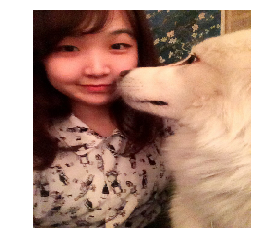

In [5]:
img = imread('tmp.jpeg')
# to PIL
img = Image.fromarray(img).resize((224, 224))
plt.imshow(img)
plt.axis('off')

In [6]:
# to numpy
img = np.array(img)
img.shape

(224, 224, 3)

---

In [7]:
tf.reset_default_graph()

- default 그래프 생성

In [8]:
graph = tf.get_default_graph()

- 현재 graph에는 아무것도 없는 상태이지만 앞으로 생성되는 operation에 대해서 이 그래프에 추가가 된다.

In [9]:
graph.get_operations()

[]

In [10]:

@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    # gradient: backpropagated Relu gradients
    # features: the outputs of Relu operation

    return tf.where(0. < grad, 
                    gen_nn_ops.relu_grad(gradients= grad,
                                         features = op.outputs[0]), 
                     tf.zeros(tf.shape(grad)))


In [11]:
def conv_layer(graph, inputs, name, stride = 1):    

    with tf.variable_scope(name) as scope:
        
        # The weights are retrieved according to how they are stored in arrays
        w = pretrained_weights[name+'_W']
        b = pretrained_weights[name+'_b']
        
        conv_weights = tf.get_variable(
                "W",
                shape=w.shape,
                initializer=tf.constant_initializer(w)
                )
        conv_biases = tf.get_variable(
                "b",
                shape=b.shape,
                initializer=tf.constant_initializer(b)
                )

        conv = tf.nn.conv2d(inputs, conv_weights, [1,stride,stride,1], padding='SAME')
        bias = tf.nn.bias_add(conv, conv_biases)
        
        with graph.gradient_override_map({'Relu': 'GuidedRelu'}):
            relu = tf.nn.relu(bias, name=name)
        
    return relu  

In [12]:
image_mean = [103.939, 116.779, 123.68]
epsilon = 1e-4

In [13]:
# Define Placeholders for images and labels
images_tf = tf.placeholder( tf.float32, [None, 224, 224, 3], name="images")
labels_tf = tf.placeholder( tf.int32, [None], name='labels')

In [14]:
r, g, b = tf.split(images_tf,[1,1,1] , 3)
print(r)
print(g)
print(b)

Tensor("split:0", shape=(?, 224, 224, 1), dtype=float32)
Tensor("split:1", shape=(?, 224, 224, 1), dtype=float32)
Tensor("split:2", shape=(?, 224, 224, 1), dtype=float32)


In [15]:
image = tf.concat([b-image_mean[0],g-image_mean[1], r-image_mean[2]],3)
image

<tf.Tensor 'concat:0' shape=(?, 224, 224, 3) dtype=float32>

- Conv1_1 output 계산 식: $(224-1)/1 +1 = 224$

In [16]:
relu1_1 = conv_layer(graph, image, "conv1_1" )
relu1_1

<tf.Tensor 'conv1_1/conv1_1:0' shape=(?, 224, 224, 64) dtype=float32>

- Conv1_2 output 계산 식: $(224-1)/1 +1 = 224$

In [17]:
relu1_2 = conv_layer(graph, relu1_1, "conv1_2" )
relu1_2

<tf.Tensor 'conv1_2/conv1_2:0' shape=(?, 224, 224, 64) dtype=float32>

- pool1 output 계산 식: $(224-2)/2 +1 = 112$

In [18]:
pool1 = tf.nn.max_pool(relu1_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')
pool1

<tf.Tensor 'pool1:0' shape=(?, 112, 112, 64) dtype=float32>

- Conv2_1 output 계산 식: $(112-1)/1 +1 = 112$

In [19]:
relu2_1 = conv_layer(graph, pool1, "conv2_1")   
relu2_1

<tf.Tensor 'conv2_1/conv2_1:0' shape=(?, 112, 112, 128) dtype=float32>

- Conv2_2 output 계산 식: $(112-1)/1 +1 = 112$

In [20]:
relu2_2 = conv_layer(graph, relu2_1, "conv2_2")
relu2_2

<tf.Tensor 'conv2_2/conv2_2:0' shape=(?, 112, 112, 128) dtype=float32>

- pool2 output 계산 식: $(112-2)/2 +1 = 56$

In [21]:
pool2 = tf.nn.max_pool(relu2_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],padding='SAME', name='pool2')
pool2

<tf.Tensor 'pool2:0' shape=(?, 56, 56, 128) dtype=float32>

- Conv3_1 output 계산 식: $(56-1)/1 +1 = 56$

In [22]:
relu3_1 = conv_layer(graph, pool2, "conv3_1")
relu3_1

<tf.Tensor 'conv3_1/conv3_1:0' shape=(?, 56, 56, 256) dtype=float32>

- Conv3_2 output 계산 식: $(56-1)/1 +1 = 56$

In [23]:
relu3_2 = conv_layer(graph, relu3_1, "conv3_2")
relu3_2

<tf.Tensor 'conv3_2/conv3_2:0' shape=(?, 56, 56, 256) dtype=float32>

- Conv3_3 output 계산 식: $(56-1)/1 +1 = 56$

In [24]:
relu3_3 = conv_layer(graph, relu3_2, "conv3_3")
relu3_3

<tf.Tensor 'conv3_3/conv3_3:0' shape=(?, 56, 56, 256) dtype=float32>

- pool3 output 계산 식: $(56-2)/2 +1 = 28$

In [25]:
pool3 = tf.nn.max_pool(relu3_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                       padding='SAME', name='pool3')
pool3

<tf.Tensor 'pool3:0' shape=(?, 28, 28, 256) dtype=float32>

- Conv4_1 output 계산 식: $(28-1)/1 +1 = 28$

In [26]:
relu4_1 = conv_layer(graph, pool3, "conv4_1")
relu4_1

<tf.Tensor 'conv4_1/conv4_1:0' shape=(?, 28, 28, 512) dtype=float32>

In [27]:
relu4_2 = conv_layer(graph, relu4_1, "conv4_2")
relu4_2

<tf.Tensor 'conv4_2/conv4_2:0' shape=(?, 28, 28, 512) dtype=float32>

In [28]:
relu4_3 = conv_layer(graph, relu4_2, "conv4_3")
relu4_3

<tf.Tensor 'conv4_3/conv4_3:0' shape=(?, 28, 28, 512) dtype=float32>

In [29]:
pool4 = tf.nn.max_pool(relu4_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                       padding='SAME', name='pool4')
pool4

<tf.Tensor 'pool4:0' shape=(?, 14, 14, 512) dtype=float32>

- Conv5_1 output 계산 식: $(14-1)/1 +1 = 14$

In [30]:
relu5_1 = conv_layer(graph, pool4, "conv5_1")
relu5_1

<tf.Tensor 'conv5_1/conv5_1:0' shape=(?, 14, 14, 512) dtype=float32>

- Conv5_2 output 계산 식: $(14-1)/1 +1 = 14$

In [31]:
relu5_2 = conv_layer(graph, relu5_1, "conv5_2")
relu5_2

<tf.Tensor 'conv5_2/conv5_2:0' shape=(?, 14, 14, 512) dtype=float32>

- Conv5_3 output 계산 식: $(14-1)/1 +1 = 14$

In [32]:
relu5_3 = conv_layer(graph, relu5_2, "conv5_3")
relu5_3

<tf.Tensor 'conv5_3/conv5_3:0' shape=(?, 14, 14, 512) dtype=float32>

In [33]:
pool5 = tf.nn.max_pool(relu5_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                       padding='SAME', name='pool5')
pool5

<tf.Tensor 'pool5:0' shape=(?, 7, 7, 512) dtype=float32>

In [34]:
with tf.variable_scope('fc1') as scope:                        

    w = pretrained_weights['fc6_W']
    b = pretrained_weights['fc6_b']

    fc_weights = tf.get_variable("W", shape=w.shape, initializer=tf.constant_initializer(w))
    fc_biases  = tf.get_variable("b", shape=b.shape, initializer=tf.constant_initializer(b))           

    # flatten dim 
    shape = int(np.prod(pool5.get_shape()[1:])) #25088 
    pool5_flat = tf.reshape(pool5, [-1, shape])

    fc1l = tf.nn.bias_add(tf.matmul(pool5_flat, fc_weights), fc_biases)

    with graph.gradient_override_map({'Relu': 'GuidedRelu'}):
        fc1 = tf.nn.relu(fc1l)

    fc1 = tf.nn.dropout(fc1, keep_prob = 1.0) # option

In [35]:
fc1

<tf.Tensor 'fc1/Relu:0' shape=(?, 4096) dtype=float32>

In [36]:
with tf.variable_scope('fc2') as scope: 

    w = pretrained_weights['fc7_W']
    b = pretrained_weights['fc7_b']

    fc_weights = tf.get_variable("W", shape=w.shape, initializer=tf.constant_initializer(w))
    fc_biases  = tf.get_variable("b", shape=b.shape, initializer=tf.constant_initializer(b))           

    fc2l = tf.nn.bias_add(tf.matmul(fc1, fc_weights), fc_biases)

    with graph.gradient_override_map({'Relu': 'GuidedRelu'}):
        fc2 = tf.nn.relu(fc2l)
    fc2 = tf.nn.dropout(fc2, keep_prob = 1.0)

In [37]:
fc2

<tf.Tensor 'fc2/Relu:0' shape=(?, 4096) dtype=float32>

In [38]:

with tf.variable_scope('fc3') as scope:

    w = pretrained_weights['fc8_W']
    b = pretrained_weights['fc8_b']

    fc_weights = tf.get_variable("W", shape=w.shape, initializer=tf.constant_initializer(w))
    fc_biases  = tf.get_variable("b", shape=b.shape, initializer=tf.constant_initializer(b))         

    output = tf.nn.bias_add(tf.matmul(fc2, fc_weights), fc_biases)

In [39]:
output

<tf.Tensor 'fc3/BiasAdd:0' shape=(?, 1000) dtype=float32>

---

# Inference

- 다시 불러온 graph의 마지막 Conv와 최종 output를 가져옴

In [40]:
last_conv_layer = graph.get_tensor_by_name('conv5_3/conv5_3:0')
last_conv_layer

<tf.Tensor 'conv5_3/conv5_3:0' shape=(?, 14, 14, 512) dtype=float32>

In [41]:
output = graph.get_tensor_by_name('fc3/BiasAdd:0')
output

<tf.Tensor 'fc3/BiasAdd:0' shape=(?, 1000) dtype=float32>

In [42]:
gradient = tf.gradients(output[:,tf.squeeze(labels_tf,-1)], last_conv_layer)[0]
gradient

<tf.Tensor 'gradients/pool5_grad/MaxPoolGrad:0' shape=(?, 14, 14, 512) dtype=float32>

$$ norm_i = \frac{grad_i}{\sqrt{\frac{1}{n}\sum grad_i^2}} $$

In [43]:
norm_grads = tf.div(gradient, tf.sqrt(tf.reduce_mean(tf.square(gradient))) + tf.constant(1e-5))
norm_grads

<tf.Tensor 'div:0' shape=(?, 14, 14, 512) dtype=float32>

In [44]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [45]:
logits_classes = sess.run(output, 
                          feed_dict={images_tf: np.expand_dims(img, axis = 0)}
                         )

In [46]:
logits_classes.shape

(1, 1000)

In [47]:
pred = np.squeeze(logits_classes, axis=0)
pred.shape

(1000,)

- 작은값부터 큰값 순서를 나타내는 index
- $[::-1] \rightarrow $ 큰값부터 작은값으로 바꾸는 인덱스 표현
- 확률(logit)이 가장 큰 5개의 class 선택

In [48]:
pred = (np.argsort(pred)[::-1])[0:6]
pred

array([258, 279, 222, 257, 270, 250])

In [49]:
label_1 = pred[0]
label_1

258

In [50]:
label_2 = pred[5]
label_2

250

---

# Gradient Class Activation Maps

In [51]:
fmaps = last_conv_layer
gradients= norm_grads 
height = 224 # upsampled height
width = 224 # upsampled width
num_fmaps = 512 # number of feature map for last conv

In [52]:
gradients.shape.as_list()

[None, 14, 14, 512]

- 각 채널 별로 평균(global average pooling)

In [53]:
weights = tf.reduce_mean(gradients, axis=(1,2))
weights.shape.as_list()

[None, 512]

 - [None, 14, 14, 512] -> [None, 224, 224, 512]

In [54]:
fmaps_resized = tf.image.resize_bilinear(fmaps, [height, width] )
fmaps_resized

<tf.Tensor 'ResizeBilinear:0' shape=(?, 224, 224, 512) dtype=float32>

In [55]:
fmaps_reshaped = tf.reshape(fmaps_resized, [-1, height*width, num_fmaps]) 
fmaps_reshaped

<tf.Tensor 'Reshape:0' shape=(?, 50176, 512) dtype=float32>

In [56]:
label_w = tf.reshape( weights, [-1, num_fmaps, 1])
label_w

<tf.Tensor 'Reshape_1:0' shape=(?, 512, 1) dtype=float32>

In [57]:
classmap = tf.matmul(fmaps_reshaped, label_w )
classmap

<tf.Tensor 'MatMul:0' shape=(?, 50176, 1) dtype=float32>

In [58]:
classmap = tf.reshape( classmap, [-1, height, width] )
classmap

<tf.Tensor 'Reshape_2:0' shape=(?, 224, 224) dtype=float32>

In [59]:
pred[0]

258

In [60]:
class_map1 = sess.run(classmap, feed_dict={ images_tf: np.expand_dims(img, axis = 0),labels_tf: [label_1]})
class_map2 = sess.run(classmap, feed_dict={ images_tf: np.expand_dims(img, axis = 0),labels_tf: [label_2]})

print(class_map1.shape)
print(class_map2.shape)


(1, 224, 224)
(1, 224, 224)


In [61]:
class_map1 = np.squeeze(class_map1, axis= 0)
class_map2 = np.squeeze(class_map2, axis= 0)

print(class_map1.shape)
print(class_map2.shape)

(224, 224)
(224, 224)


In [62]:
class_map1

array([[  11.326534,   10.256481,    9.186434, ..., -139.50922 ,
        -139.50922 , -139.50922 ],
       [  11.11174 ,   10.066767,    9.021786, ..., -128.73962 ,
        -128.73962 , -128.73962 ],
       [  10.896954,    9.877047,    8.857143, ..., -117.97    ,
        -117.97    , -117.97    ],
       ...,
       [  60.042534,   56.245735,   52.44895 , ...,   75.687744,
          75.687744,   75.687744],
       [  60.042534,   56.245735,   52.44895 , ...,   75.687744,
          75.687744,   75.687744],
       [  60.042534,   56.245735,   52.44895 , ...,   75.687744,
          75.687744,   75.687744]], dtype=float32)

In [63]:
class_map2

array([[   9.975134,    9.379017,    8.782894, ..., -125.02382 ,
        -125.02382 , -125.02382 ],
       [  10.092278,    9.504257,    8.916239, ..., -116.4028  ,
        -116.4028  , -116.4028  ],
       [  10.209423,    9.629507,    9.049589, ..., -107.7818  ,
        -107.7818  , -107.7818  ],
       ...,
       [  66.320564,   62.716473,   59.11238 , ...,   62.742596,
          62.742596,   62.742596],
       [  66.320564,   62.716473,   59.11238 , ...,   62.742596,
          62.742596,   62.742596],
       [  66.320564,   62.716473,   59.11238 , ...,   62.742596,
          62.742596,   62.742596]], dtype=float32)

---

# Visiualize

In [64]:
def normalize(img):
    """Normalize the image range for visualization"""
    return np.uint8((img - img.min()) / (img.max()-img.min())*255)

(-0.5, 223.5, 223.5, -0.5)

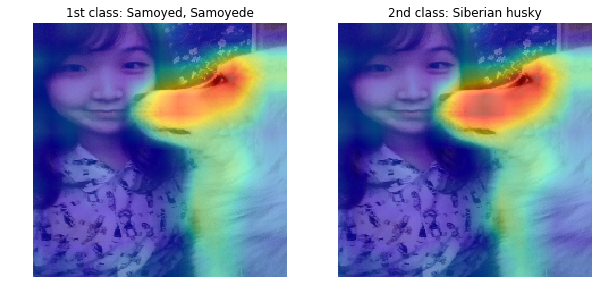

In [65]:
fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(img)
axs[0].imshow(normalize(class_map1), cmap=plt.cm.jet, alpha=0.5, interpolation='nearest')
axs[0].set_title('1st class: %s' %class_names[label_1])
axs[0].axis('off')

axs[1].imshow(img)
axs[1].imshow(normalize(class_map2), cmap=plt.cm.jet, alpha=0.5, interpolation='nearest')
axs[1].set_title('2nd class: %s' %class_names[label_2])
axs[1].axis('off')

In [66]:
heatmap = class_map1
threshold = 0.3

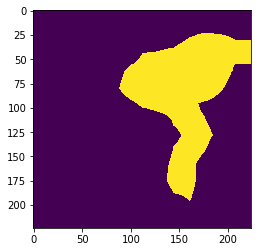

In [67]:
# Binarize the heatmap
_, thresholded_heatmap = cv2.threshold(heatmap, threshold * heatmap.max(), 1, cv2.THRESH_BINARY)
plt.imshow(thresholded_heatmap)

In [68]:
# Required for converting image to uint8
print('Before:',thresholded_heatmap.dtype)
thresholded_heatmap = cv2.convertScaleAbs(thresholded_heatmap)
print('After:',thresholded_heatmap.dtype)

Before: float32
After: uint8


In [69]:
contours, _ = cv2.findContours(thresholded_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('number of contours:',len(contours))

number of contours: 1


- contours 면적 계산

In [70]:
contour_areas = []   
for i, c in enumerate(contours):
    contour_areas.append(cv2.contourArea(c))

In [71]:
# contour 면적이 큰 순서대로 정렬
sorted_contours = sorted(zip(contour_areas, contours), key=lambda x:x[0], reverse=True)

In [72]:
# # contour 면적이 큰 contours 선택
biggest_contour= sorted_contours[0][1]

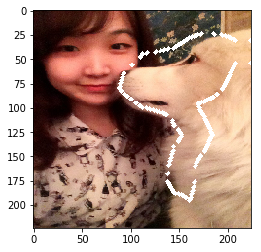

In [73]:
# -1 : represent entire contours
# (255, 255, 255): color
# 3 : thinkness 
contour_image = cv2.drawContours(img.copy(), biggest_contour, -1, (255, 255, 255), 3)
plt.imshow(contour_image)

In [74]:
x,y,w,h = cv2.boundingRect(biggest_contour)
x,y,w,h

(88, 24, 136, 172)

In [75]:
box_image = cv2.rectangle(img.copy(), (x,y), (x+w, y+h), (0, 255,0), 2)

(-0.5, 223.5, 223.5, -0.5)

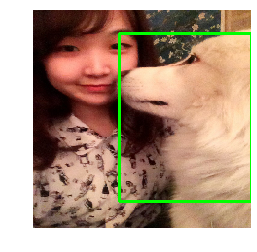

In [76]:
plt.imshow(box_image)
plt.axis('off')

---

- 마지막 Conv가 아닌 input image에 대해서 gradients를 계산

In [77]:
gradient_bp = tf.gradients(output[:,tf.squeeze(labels_tf,-1)], images_tf)[0]
gradient_bp

<tf.Tensor 'gradients_1/split_grad/concat:0' shape=(?, 224, 224, 3) dtype=float32>

- gradient normalize

In [78]:
norm_grads_bp = tf.div(gradient_bp, tf.sqrt(tf.reduce_mean(tf.square(gradient))) + tf.constant(1e-5))
norm_grads_bp

<tf.Tensor 'div_1:0' shape=(?, 224, 224, 3) dtype=float32>

In [79]:
# Gradients computation
grads_weights1 = sess.run(norm_grads_bp, feed_dict={images_tf: np.expand_dims(img, axis = 0),
                                               labels_tf: [label_1]})
grads_weights2 = sess.run(norm_grads_bp, feed_dict={images_tf: np.expand_dims(img, axis = 0),
                                               labels_tf: [label_2]})


In [80]:
grads_weights1 = np.squeeze(grads_weights1)
grads_weights2 = np.squeeze(grads_weights2)

- MinMax uint8 normalize

(-0.5, 223.5, 223.5, -0.5)

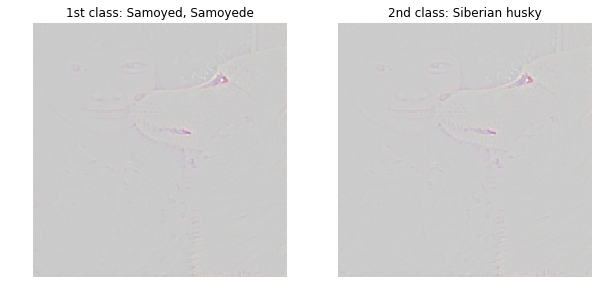

In [81]:
fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(normalize(grads_weights1), cmap=plt.cm.jet, alpha=0.5, interpolation='nearest')
axs[0].set_title('1st class: %s' %class_names[label_1])
axs[0].axis('off')

axs[1].imshow(normalize(grads_weights2), cmap=plt.cm.jet, alpha=0.5, interpolation='nearest')
axs[1].set_title('2nd class: %s' %class_names[label_2])
axs[1].axis('off')

- gradients w.r.t image
- gradients w.r.t last conv

In [130]:
def saliency_normalize(img):
    """Normalize the image range for visualization"""
    return (img - img.min()) / (img.max()-img.min())

In [132]:
# range 0 ~ 1
saliency_normalize(class_map1)

array([[0.16219318, 0.16104256, 0.15989193, ..., 0.        , 0.        ,
        0.        ],
       [0.16196221, 0.16083856, 0.15971489, ..., 0.01158051, 0.01158051,
        0.01158051],
       [0.16173124, 0.16063455, 0.15953785, ..., 0.02316104, 0.02316104,
        0.02316104],
       ...,
       [0.21457733, 0.21049462, 0.20641196, ..., 0.23140056, 0.23140056,
        0.23140056],
       [0.21457733, 0.21049462, 0.20641196, ..., 0.23140056, 0.23140056,
        0.23140056],
       [0.21457733, 0.21049462, 0.20641196, ..., 0.23140056, 0.23140056,
        0.23140056]], dtype=float32)

In [154]:
gradBGR1 = normalize(grads_weights1)
# VGG16 use BGR internally, so we manually change BGR to RGB
gradRGB_cam1 = np.dstack((
    normalize(gradBGR1[:, :, 2]* saliency_normalize(class_map1)),
    normalize(gradBGR1[:, :, 1]* saliency_normalize(class_map1)),
    normalize(gradBGR1[:, :, 0]* saliency_normalize(class_map1))
))

gradBGR2 = normalize(grads_weights2)
# VGG16 use BGR internally, so we manually change BGR to RGB
gradRGB_cam2 = np.dstack((
    normalize(gradBGR2[:, :, 2]* saliency_normalize(class_map2)),
    normalize(gradBGR2[:, :, 1]* saliency_normalize(class_map2)),
    normalize(gradBGR2[:, :, 0]* saliency_normalize(class_map2))
))

(-0.5, 223.5, 223.5, -0.5)

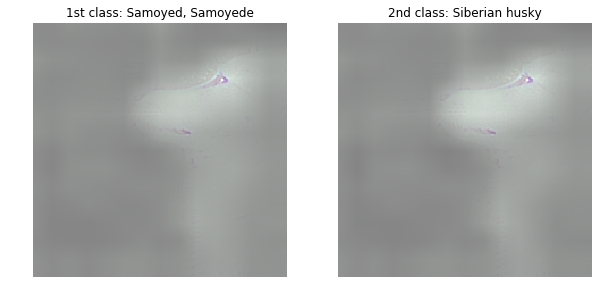

In [155]:
fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(gradRGB_cam1, cmap=plt.cm.jet, alpha=0.5, interpolation='nearest')
axs[0].set_title('1st class: %s' %class_names[label_1])
axs[0].axis('off')

axs[1].imshow(gradRGB_cam2, cmap=plt.cm.jet, alpha=0.5, interpolation='nearest')
axs[1].set_title('2nd class: %s' %class_names[label_2])
axs[1].axis('off')

---

In [82]:
loss_tf = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=output, labels= labels_tf ), name='loss_tf')
loss_tf

<tf.Tensor 'loss_tf:0' shape=() dtype=float32>

In [83]:
tf.trainable_variables() 

[<tf.Variable 'conv1_1/W:0' shape=(3, 3, 3, 64) dtype=float32_ref>,
 <tf.Variable 'conv1_1/b:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'conv1_2/W:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'conv1_2/b:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'conv2_1/W:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'conv2_1/b:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'conv2_2/W:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 <tf.Variable 'conv2_2/b:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'conv3_1/W:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'conv3_1/b:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'conv3_2/W:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'conv3_2/b:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'conv3_3/W:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'conv3_3/b:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'conv4_1/W:0' shape=(3, 3, 256, 512) dtype=float32_ref>,
 <tf.Variable

- filter의 결과값은 한번 출력되면 사라지는 것을 주의

In [84]:
weights_only = filter( lambda x: x.name.endswith('W:0'), tf.trainable_variables() )
list(weights_only)

[<tf.Variable 'conv1_1/W:0' shape=(3, 3, 3, 64) dtype=float32_ref>,
 <tf.Variable 'conv1_2/W:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'conv2_1/W:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'conv2_2/W:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 <tf.Variable 'conv3_1/W:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'conv3_2/W:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'conv3_3/W:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'conv4_1/W:0' shape=(3, 3, 256, 512) dtype=float32_ref>,
 <tf.Variable 'conv4_2/W:0' shape=(3, 3, 512, 512) dtype=float32_ref>,
 <tf.Variable 'conv4_3/W:0' shape=(3, 3, 512, 512) dtype=float32_ref>,
 <tf.Variable 'conv5_1/W:0' shape=(3, 3, 512, 512) dtype=float32_ref>,
 <tf.Variable 'conv5_2/W:0' shape=(3, 3, 512, 512) dtype=float32_ref>,
 <tf.Variable 'conv5_3/W:0' shape=(3, 3, 512, 512) dtype=float32_ref>,
 <tf.Variable 'fc1/W:0' shape=(25088, 4096) dtype=float32_ref>,
 <tf.Variable 'fc2/

In [85]:
weights_only = filter( lambda x: x.name.endswith('W:0'), tf.trainable_variables() )
[tf.nn.l2_loss(x) for x in list(weights_only)]

[<tf.Tensor 'L2Loss:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_1:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_2:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_3:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_4:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_5:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_6:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_7:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_8:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_9:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_10:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_11:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_12:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_13:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_14:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_15:0' shape=() dtype=float32>]

In [86]:
weights_only = filter( lambda x: x.name.endswith('W:0'), tf.trainable_variables() )
weight_decay = tf.reduce_sum(tf.stack([tf.nn.l2_loss(x) for x in weights_only])) * 0.0005 # decay rate
weight_decay

<tf.Tensor 'mul:0' shape=() dtype=float32>

In [87]:
loss_tf += weight_decay

- 위 loss를 손실함수로 두고 학습하면 된다.
- 정확도에 대한 op는 아래와 같이 정의 할 수 있다.

In [88]:
tf.argmax(output, 1)

<tf.Tensor 'ArgMax:0' shape=(?,) dtype=int64>

- argmax의 output 자료형 또한 변환시킬 수 있다.

In [89]:
correct_pred = tf.equal(tf.argmax(output, 1, output_type=tf.int32), labels_tf)
correct_pred

<tf.Tensor 'Equal:0' shape=(?,) dtype=bool>

In [90]:
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
accuracy

<tf.Tensor 'Mean_3:0' shape=() dtype=float32>